In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd
import pickle as pickle

from array import array
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# my project
from module.conf import PROJECT_DIR

# %matplotlib tk
%matplotlib inline


In [2]:
def read_images_labels(data_filepath) -> tuple:
    labels = []
    images = []
    for path in data_filepath:
        with open(file = path, mode="rb") as f:
            dict_data = pickle.load(file=f, encoding="bytes")
            dd = dict_data[b'data']
            # for key in dict_data.keys():
            #     print(f"{key}")
            #     pass
            for ind, val in enumerate(dd):
                # print(f"data[{ind}]:{val}")
                label = dict_data[b'fine_labels'][ind]
                img = np.asarray(dd[ind], dtype=np.uint8).reshape(3, 32, 32).transpose(1, 2, 0)
                labels.append(label)
                images.append(img)
                pass
            pass
        pass
    return np.asarray(images), np.asarray(labels)

def load_data() -> tuple:
    cifar_path = "/data/sample/cifar-100-python"
    label_name_filepath = "".join([PROJECT_DIR, cifar_path, "/meta"])
    training_data_filepaths = [
        "".join([PROJECT_DIR, cifar_path, "/train"]), 
    ]
    test_data_filepaths = ["".join([PROJECT_DIR, cifar_path, "/test"])]
    x_train, y_train = read_images_labels(training_data_filepaths[:])
    x_test, y_test = read_images_labels(test_data_filepaths)
    with open(file=label_name_filepath, mode="rb") as f:
        label = pickle.load(file=f, encoding="bytes")
        label_names = label[b'fine_label_names']
        # print(f"fine:{len(label_names)}")
        # print(f"coarse:{len(label[b'coarse_label_names'])}")
        pass
    return (x_train, y_train),(x_test, y_test), label_names

(X_train, y_train), (X_test, y_test), label_names = load_data()

In [3]:
# print(X_train.dtype)
X_train = X_train.astype(dtype=np.float64) / 255
X_test = X_test.astype(dtype=np.float64) / 255
# for i in range(len(X_train)): X_train[i] /= 255
# for i in range(len(X_test)): X_test[i] /= 255 

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(32, 32, 3)))
#------------------------------------
# Conv Block 1: 32 Filters, MaxPool.
#------------------------------------
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#------------------------------------
# Conv Block 2: 64 Filters, MaxPool.
#------------------------------------
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#------------------------------------
# Conv Block 3: 64 Filters, MaxPool.
#------------------------------------
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
#------------------------------------
# Flatten the convolutional features.
#------------------------------------
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [5]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.categorical_crossentropy
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy", "mae"])
# model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3),
#             loss=loss_fn,
#             metrics=["accuracy"])

# model.compile(optimizer='rmsprop', 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

Don't fit in PC, let do it on cloud

In [6]:
# model.fit(x=X_train, y=y_train, epochs=32, batch_size=500, verbose=1)
# model.fit(x=X_train, y=y_train, epochs=16, batch_size=512, verbose=1)

In [7]:
model.evaluate(X_test, y_test, verbose=2)
result = model.predict(x=np.asarray([X_test[0]], dtype=np.float64), verbose=1)
# result = tf.nn.softmax(result).numpy()
print(f"{result}")
print(f"{result.argmax()} {y_test[0]}")

2023-09-15 13:50:00.393759: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 - 2s - loss: 0.2302 - accuracy: 0.0113 - mae: 49.4021 - 2s/epoch - 7ms/step
1/1 [==============================] - 0s 84ms/step
[[0.10312351 0.10080624 0.09938423 0.10439794 0.0997704  0.1029591
  0.09293153 0.09920973 0.10324991 0.09416743]]
3 49


In [1]:
c = 0
cp = 0
for i in range(100):
    test_indx = rd.randint(0, len(y_test)-1)
    x_test_ = np.asarray([X_test[test_indx]])

    # test_indx = rd.randint(0, len(y_train)-1)
    # x_test_ = np.asarray([X_train[test_indx]])

    result = model.predict(x=x_test_, verbose=0) 
#     result = tf.nn.softmax(result).numpy()
    y_test_ = y_test
    if result.max() >= 0.5:
        if result.argmax() != y_test_[test_indx]:
            c+=1
            print(f"- [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} {label_names[result.argmax()]} solve:{y_test_[test_indx]} {label_names[y_test_[test_indx]]}")
    else:
        print(f"can not predict:{test_indx}: {result.max()}")
        cp+=1
print(f"error: {c} can not pred:{cp}")

NameError: name 'rd' is not defined

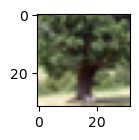

label[52]:b'oak_tree'


In [9]:
ind = 140
%matplotlib inline
fig, ax = plt.subplots(figsize=(1.6, 1.2))
ax.imshow(X=X_train[ind])
plt.show()
print(f"label[{y_train[ind]}]:{label_names[y_train[ind]]}")

# print(f"{X_train.shape}")

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#   # Disable first GPU
#   tf.config.set_visible_devices(physical_devices[1:], 'GPU')
#   logical_devices = tf.config.list_logical_devices('GPU')
#   # Logical device was not created for first GPU
#   assert len(logical_devices) == len(physical_devices) - 1
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# tf.config.list_physical_devices()

2. Resnet

In [12]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
resnet_model = tf.keras.applications.ResNet50(input_shape=(32, 32, 3), include_top=True, weights=None, classes=100)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy"])

# resnet_model.summary()
# resnet_model.save()
resnet_model.fit(x=X_train, y=y_train, epochs=5, batch_size=512, verbose=1)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
# model.fit(x_train, y_train, epochs=5, batch_size=64)

Epoch 1/5
114/782 [===>..........................] - ETA: 1:35 - loss: 5.2360 - accuracy: 0.0322

KeyboardInterrupt: 